# 01 Import libraries

In [1]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import pandas as pd

In [ ]:
# import importlib

## Import our own modules

In [4]:
# !rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 1744, done.
remote: Counting objects: 100% (714/714), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 1744 (delta 542), reused 479 (delta 359), pack-reused 1030 (from 1)
Receiving objects: 100% (1744/1744), 13.25 MiB | 3.18 MiB/s, done.
Resolving deltas: 100% (1179/1179), done.


(Using Colab)

In [5]:
import sys

In [6]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [7]:
import lib
# importlib.reload(lib)

In [8]:
from lib.fast_tensor_data_loader import FastTensorDataLoader
from lib.lsp.basis_generator import dampen_laguerre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.reg_solver_lsp import train_lsp, test_lsp
from lib.lsp.loss_fn_lsp import reg_exp_weighted_logit

#Learning the Solution Path Through SGD
Now, let us run SGD over random $\tilde λ$'s with a linear basis $\Phi(\tilde \lambda)$ of our choice. We want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function is $\min_\beta h(\Phi(\tilde\lambda)\beta, \tilde\lambda) = (1-\tilde\lambda) BCE(X_\text{pass}\Phi(\tilde\lambda)\beta,\ y_\text{pass}) + \tilde\lambda BCE(X_\text{fail}\Phi(\tilde\lambda)\beta,\ y_\text{fail})$. For each batch of training data set, we randomize $\tilde\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

# 02 Load data

In [9]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [10]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [11]:
train_X = torch.tensor(X, dtype=torch.float32)
train_y = torch.tensor(y, dtype=torch.float32)

In [12]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=20, shuffle=True, )
# test data
test_data_loader = FastTensorDataLoader(train_X, train_y, batch_size=1000, shuffle=False, )

In [13]:
lam_max = 20
lam_min = 0
input_dim = X.shape[1]

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
# Read the CSV file into a DataFrame
# truth = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/results/exact_soln_list.csv')
truth = pd.read_csv('exact_soln_list_laguerre.csv')

# Display the DataFrame
truth

,losses,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,...,theta_36,theta_37,theta_38,theta_39,theta_40,theta_41,theta_42,theta_43,theta_44,theta_45
0,0.251592,-0.290164,0.186074,0.232884,-0.027476,0.166136,0.110354,0.142358,0.009975,0.157656,...,0.000471,0.023097,-0.007038,0.003151,0.004510,-0.024440,0.000471,-0.129229,-0.096597,-0.041242
1,0.251645,-0.290092,0.186073,0.232887,-0.027478,0.166136,0.110326,0.142336,0.009961,0.157669,...,0.000487,0.023069,-0.007039,0.003154,0.004514,-0.024434,0.000487,-0.129220,-0.096579,-0.041224
2,0.251698,-0.290020,0.186071,0.232891,-0.027481,0.166136,0.110298,0.142315,0.009946,0.157682,...,0.000503,0.023042,-0.007041,0.003157,0.004518,-0.024429,0.000503,-0.129210,-0.096561,-0.041206
3,0.251751,-0.289947,0.186070,0.232895,-0.027484,0.166136,0.110270,0.142294,0.009931,0.157695,...,0.000519,0.023015,-0.007042,0.003160,0.004522,-0.024423,0.000519,-0.129201,-0.096543,-0.041188
4,0.251804,-0.289874,0.186068,0.232898,-0.027487,0.166136,0.110242,0.142272,0.009916,0.157708,...,0.000534,0.022988,-0.007043,0.003162,0.004526,-0.024417,0.000534,-0.129191,-0.096525,-0.041170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,0.425709,0.608973,0.015982,0.030750,-0.012680,0.033522,-0.189898,-0.060873,-0.075246,0.138251,...,0.104496,-0.190631,-0.003899,0.016846,0.022910,0.049139,0.104496,0.117941,0.139251,0.161150
1020,0.405809,0.627298,0.006731,0.017247,-0.013635,0.025534,-0.197376,-0.075369,-0.070611,0.125166,...,0.104706,-0.193085,-0.002800,0.016029,0.021890,0.052167,0.104706,0.126507,0.144123,0.163584
1021,0.382318,0.647696,-0.004087,0.001661,-0.014793,0.016128,-0.205935,-0.094402,-0.064959,0.109066,...,0.104903,-0.195830,-0.001589,0.015089,0.020769,0.055620,0.104903,0.136154,0.149574,0.166138
1022,0.354260,0.670989,-0.016946,-0.016535,-0.016181,0.004871,-0.216011,-0.119855,-0.058109,0.089182,...,0.105111,-0.199002,-0.000252,0.014026,0.019573,0.059569,0.105111,0.147241,0.155866,0.168880


In [16]:
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30', 'theta_31', 'theta_32', 'theta_33', 'theta_34',
                    'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39',
                    'theta_40', 'theta_41', 'theta_42', 'theta_43', 'theta_44',
                    'theta_45']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

# 03 Visualizing convergence of LSP

We use a coefficient profile plot for an arbitrarily selected coefficient (3) to visualize the convergence of our model.

In [17]:
loss_fn = reg_exp_weighted_logit

In [18]:
phi_lam = dampen_laguerre

In [19]:
num_grid = 2**10
lambdas = np.linspace(lam_max, lam_min, num_grid)
delta_lam = (lam_max - lam_min)/(num_grid - 1)

In [20]:
coeff_index = 3

#### Coefficient plot when we use exact gradient.

In [21]:
trace = 50 # run this again before plotting

In [22]:
# build the model
basis_dim = 7
epochs = trace * (2**3)
lr = 0.0625

np.random.seed(8675309)
torch.manual_seed(8675309)
thetas_SGD_history = []
model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
weight = model.linear.weight.clone().detach()
itr = 0
for t in range(epochs):
    grad, weight, itr = train_lsp(itr, weight, GD_data_loader, model, loss_fn,
                                  optimizer, weighted_avg=True, step_size=None,
                                  const=None, distribution='exponential', device='cpu')
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [23]:
trace = 50 # run this again before plotting

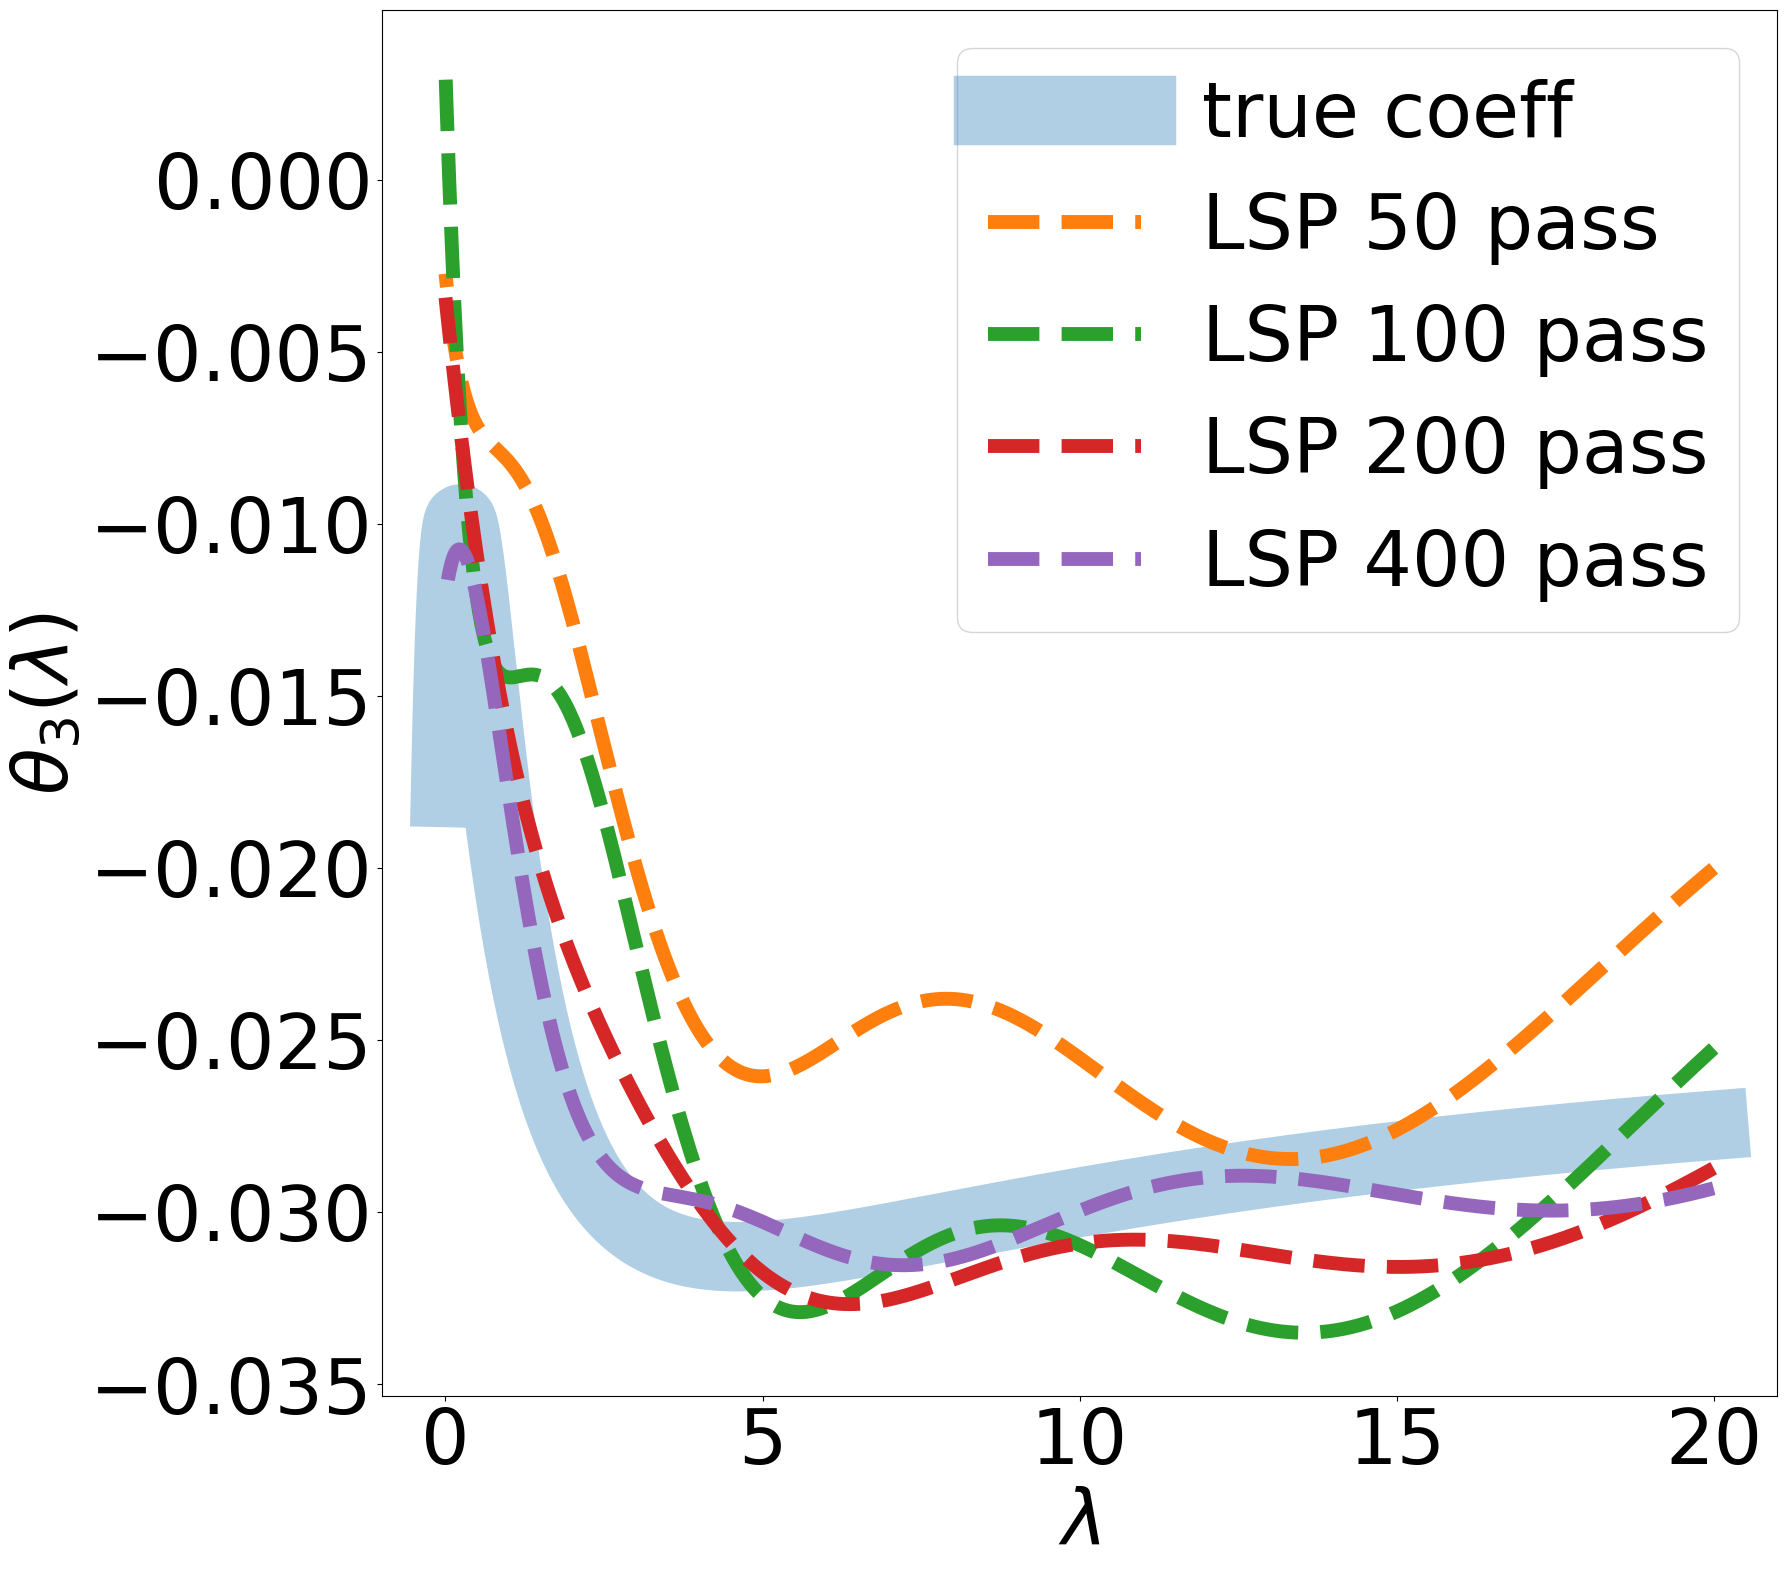

In [24]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=50, label=f'true coeff', alpha=0.35)

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=10, label=f'LSP {trace*(2**i)} pass')

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)

# plt.title('Exact Gradient')

# plt.ylim(-2, 1)
# Add legend
plt.legend(fontsize=font_size)

# Show the plot
# plt.show()

# save figure
plt.savefig("CPP_exact_3.png")


### Coefficient profile plot when we use noisy gradient

In [25]:
trace = 100 # run this again before plotting

In [26]:
# beta/sqrt(t)
def step_size(t, beta):
    return beta/np.sqrt(t+1)

In [27]:
# build the model
basis_dim = 7
epochs = trace * (2**3)
beta = 0.125

np.random.seed(8675309)
torch.manual_seed(8675309)
thetas_SGD_history = []
model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.zero_grad()
weight = model.linear.weight.clone().detach()
itr = 0
for t in range(epochs):
    grad, weight, itr = train_lsp(itr, weight, SGD_data_loader, model, loss_fn,
                                  optimizer, weighted_avg=True, step_size=step_size,
                                  const=beta, distribution='exponential', device='cpu')
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [28]:
trace = 100 # run this again before plotting

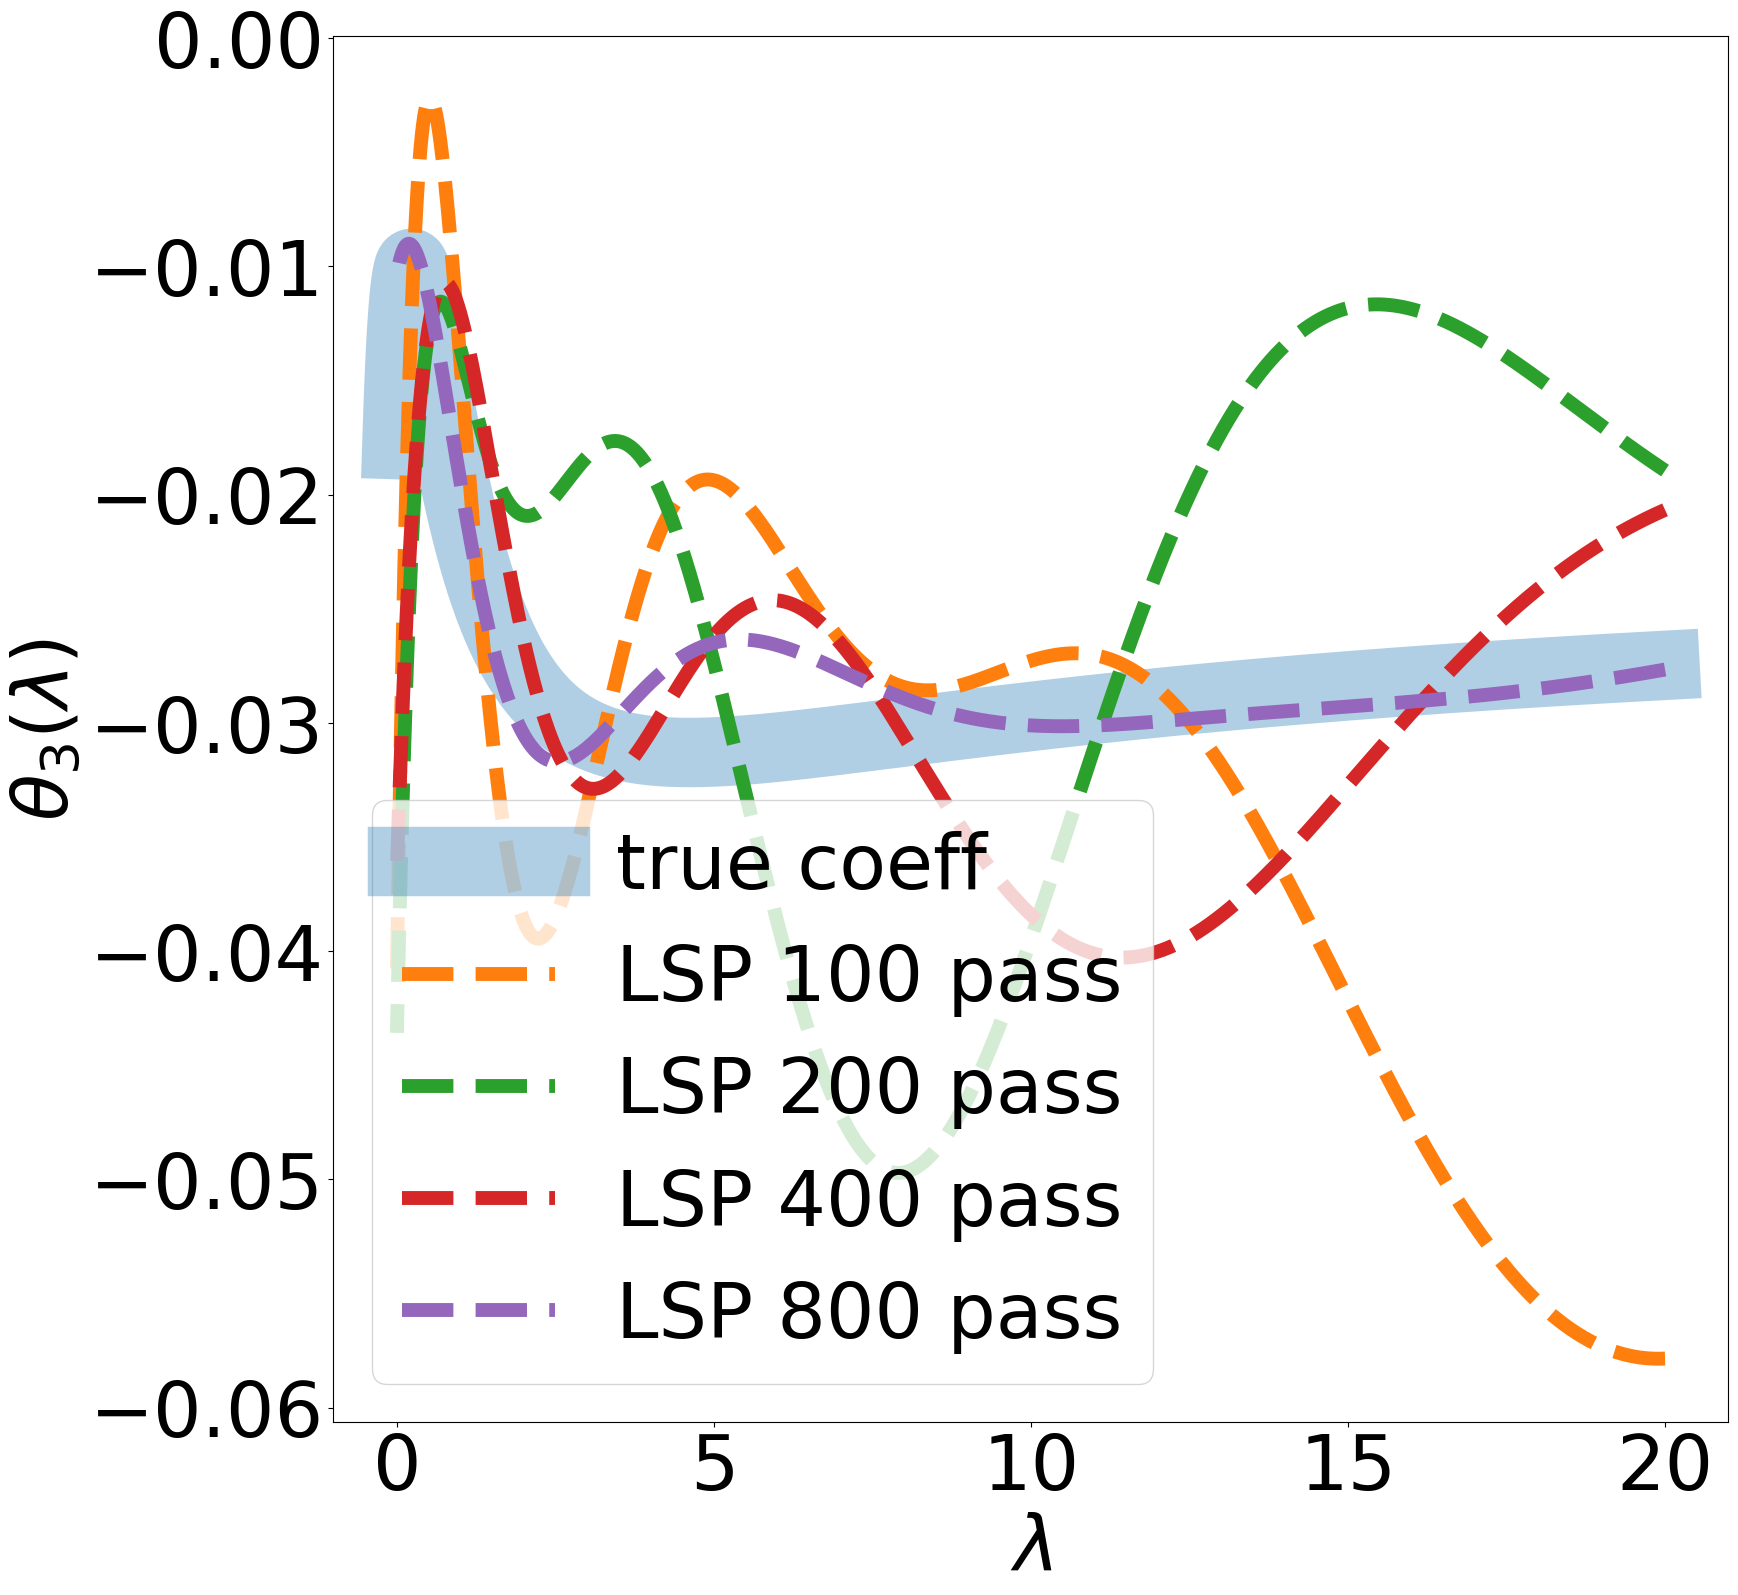

In [29]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=50, label=f'true coeff', alpha=0.35)

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=10, label=f'LSP {trace*(2**i)} pass')

# Set global font size
mpl.rcParams['font.size'] = 55

font_size = 55
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)

# plt.title('Noisy Gradient')

# plt.ylim(-2, 1)
# Add legend
plt.legend(fontsize=font_size)

# Show the plot
# plt.show()

# save figure
plt.savefig("CPP_noisy_3.png")
